#### Assignment 3

# Author: Ashutosh Ekade

#### Question 1

Posted on absalon is a press release from the European Securities and Markets Authoriy regarding its decision to prohibit sales of binary options to retail investors. Read the [article](https://www.esma.europa.eu/press-news/esma-news/esma-agrees-prohibit-binary-options-and-restrict-cfds-protect-retail-investors) and answer the following questions:

1. What is the motivation behind this decision? How does this relate to the models we have seen in class?

2. What eﬀect will this decision have on liquidity in the binary options market?

3. Measures announced in the press release diﬀer between the binary option and CFD markets. How will the eﬀects of the regulation be diﬀerent across the two markets?

Be concise and to the point. Please try to keep your answer less than 100 words (but not just one sentense).

Solution 1

1. The motivation behind decision is for protecting the retail investors as the underlying products are quite complex and this in turn results in heavy losses in retail accounts (74-89%). Moreover, there is lack of transparency in these products. The models we have seen in class overlook irrational investor behaviors and assume that the markets are efficient, which is not the case always. Information assymetry results in the profits favouring the providers of these products over the retail investors.

2. This decision of prohibiting the distribution and marketing of these contracts will significantly reduce the liquidity of the binary options. Bid-ask spreads may become wider, leading to inefficient markets.

3. Complete ban in the binary option contracts will potential losses for retail investors, reduce liquidity and widen the bid-ask spreads. Stricter regulations like leverage limits, margin close-out rules, and negative balance protection in CFDs will aim to reduce losses and risks for retail investors. However, these restrictions may also reduce market participation and liquidity, increase costs for compliant providers, potentially impacting overall market size. Overall, the decision prioritizes investor protection over market efficiency in these specific cases due to the significant risks identified.

#### Question 2 Trade data 
In the following use the trade data in tqBAC.csv.  Denote trade prices by $p_t$ and mid-quotes by $m_t$.
* Sign each trade based on Lee-ready algorithm 
* Calcualte Spread, Effective Spread and Realized Spread by EXCHANGES
* Examine order correlation 

#### Import the relevant modules

In [1]:
### In this project, I will use datatable (quicker) rather pandas to manipulate data. You can see which one is more intuitive for you
from datetime import datetime, timedelta
import datatable as dt
from datatable import dt, f, by, update, shift
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import os


#### Lee and Ready algorithm 
In the database reported by exchanges, the buyer and seller identify is not revealed. This is very different from bond database you worked in the previous assignment, which was reported by dealers and records the trade direction of dealers. Given that every trade involves buyers and sellers, how do we know which side market maker (liquidity supplier) stands and customers (liquidity demander) stands? The simple answer is given by the Lee and Ready algorithm as follows. The idea is to assign trade directions based on wheter trades happen around ask or bid prices. 

A typical classification is 
 *   buyer-initiated  if pt > mt
 *   buyer-initiated  if pt = mt and pt > pt−1 (downtick)
 *   seller-initiated if pt < mt
 *   seller-initiated if pt = mt and pt < pt−1 (uptick)

In [2]:
trade_df = dt.fread('./tqBAC.csv')
trade_df = trade_df[:, f[:].extend({"pt_1": dt.shift(f.PRICE, n=1)})]
print(trade_df.shape)
print(trade_df.head())

(24460, 11)
   | date                      SYMBOL  EX       PRICE    SIZE  COND      BID  BIDSIZ      OFR  OFRSIZ     pt_1
   | str32                     str32   str32  float64   int32  void  float64   int32  float64   int32  float64
-- + ------------------------  ------  -----  -------  ------  ----  -------  ------  -------  ------  -------
 0 | 2017-09-19T14:30:00.009Z  BAC     P       24.7     20000    NA    24.72       6    24.74     100   NA    
 1 | 2017-09-19T14:30:01.361Z  BAC     T       24.71      300    NA    24.72       6    24.74     100   24.7  
 2 | 2017-09-19T14:30:01.525Z  BAC     P       24.7       100    NA    24.72       6    24.74     100   24.71 
 3 | 2017-09-19T14:30:02.990Z  BAC     N       24.73   429950    NA    24.72       6    24.74     100   24.7  
 4 | 2017-09-19T14:30:02.996Z  BAC     N       24.72      100    NA    24.72      35    24.74     420   24.73 
 5 | 2017-09-19T14:30:03.006Z  BAC     T       24.725     200    NA    24.72       9    24.73       

In [3]:
# Extract BID and OFR values
bid_values = trade_df[:, 'BID'].to_numpy().flatten()
ofr_values = trade_df[:, 'OFR'].to_numpy().flatten()

# Calculate mt (average of BID and OFR)
mt = (bid_values + ofr_values) / 2
trade_df = trade_df[:, f[:].extend({"mt": mt})]
# Calculate pt-1
pt_1 = dt.shift(trade_df[:, 'PRICE'])

# Extract PRICE values
pt_1_values = pt_1[:, 0].to_numpy().flatten()

# Calculate pt
pt = trade_df[:, 'PRICE'].to_numpy().flatten()

# Calculate classification based on provided logic
buyer_initiated = (pt > mt) | ((pt == mt) & (pt > pt_1_values))
seller_initiated = (pt < mt) | ((pt == mt) & (pt < pt_1_values))

# Update COND column based on classification
trade_df[:, dt.update(COND=dt.ifelse(buyer_initiated, 1, dt.ifelse(seller_initiated, -1, 0)))]

# Print the updated datatable
print(trade_df)

      | date                      SYMBOL  EX       PRICE    SIZE   COND      BID  BIDSIZ      OFR  OFRSIZ     pt_1       mt
      | str32                     str32   str32  float64   int32  int32  float64   int32  float64   int32  float64  float64
----- + ------------------------  ------  -----  -------  ------  -----  -------  ------  -------  ------  -------  -------
    0 | 2017-09-19T14:30:00.009Z  BAC     P      24.7      20000     -1    24.72       6   24.74      100  NA       24.73  
    1 | 2017-09-19T14:30:01.361Z  BAC     T      24.71       300     -1    24.72       6   24.74      100  24.7     24.73  
    2 | 2017-09-19T14:30:01.525Z  BAC     P      24.7        100     -1    24.72       6   24.74      100  24.71    24.73  
    3 | 2017-09-19T14:30:02.990Z  BAC     N      24.73    429950      1    24.72       6   24.74      100  24.7     24.73  
    4 | 2017-09-19T14:30:02.996Z  BAC     N      24.72       100     -1    24.72      35   24.74      420  24.73    24.73  
    5 | 

#### Calcualte Spread, Effective Spread and Realized Spread by EXCHANGES
There are multiple ways to measure spreads in realty for different purposes. Moreoever, in order to compare spreads across stocks, it is common to normalized spread based on prices. For example, the spread of Bitcoin is larger than the spread of AMC, simply because Bitcoin trades at \$50000 per unit whereas AMC trades at a few dollars per unit.    
1. Quoted spread: $S_t = \frac{a_t - b_t}{m_t}$, where $m_t = \frac{a_t + b_t}{2}$. This is simple bid-ask spread telling you about the potential cost of trading. 
2. Effective spread: $S_t = d_t(p_t - m_t)$, where $d_t$ is the trade direction (1 for buyer-initiated and -1 for seller initiaed). In reality, because of high-frequency traders (remind HFs can cancell orders and post another one before your orders arrive at exhcnages), the actually transaction price can differ from bid and ask prices you see. This effective spread is the actual transaction cost one pays. 
3. Realized spread: $S_t = d_t(p_t - m_{t+\Delta})$. Imagine that you bought some shares at $t$, then the price moves to a new level $m_{t+\Delta}$ because of realization of information or other things, then the actual spread paid can be negative if the news are good and larger if the news are bad. This is the measure more relavent to market makers as this measures how much a market maker for providing liqudity over time $t$ to $t+\Delta$. 

In this exercise, please calcuate different spreads, and check some summary statistics for these spreads. Note that for realized spread, using mid-quote in 10 mins 
1. calcate correlation of three spreads
2. plot time series of three spreads by hour 
3. calcuate mean spreads at the Exchange level 

In [4]:
# Extract BID and OFR values
bid_values = trade_df[:, 'BID'].to_numpy().flatten()
ofr_values = trade_df[:, 'OFR'].to_numpy().flatten()

# Calculate mt (average of BID and OFR)
mt = (bid_values + ofr_values) / 2

# Calculate pt-1
pt_1 = dt.shift(trade_df[:, 'PRICE'])
# Extract PRICE values
pt = trade_df[:, 'PRICE'].to_numpy().flatten()

# Calculate classification based on provided logic
buyer_initiated = (pt > mt) | ((pt == mt) & (pt > pt_1.to_numpy().flatten()))
seller_initiated = (pt < mt) | ((pt == mt) & (pt < pt_1.to_numpy().flatten()))

# Update COND column based on classification
trade_df[:, dt.update(COND=dt.ifelse(buyer_initiated, 1, dt.ifelse(seller_initiated, -1, 0)))]

# Calculate Quoted Spread
quoted_spread = (ofr_values - bid_values) / mt

# Calculate Effective Spread
trade_direction = dt.ifelse(buyer_initiated, 1, -1)
effective_spread = trade_direction * (pt - mt)
print(quoted_spread.shape)

# Calculate Realized Spread
trade_df[:, 'date'] = dt.Type.time64
m_t_plus_delta_values = []
for i in range(trade_df.nrows):
    temp_trade_df = trade_df.copy()
    m_t_plus_delta_values.append(temp_trade_df[f.date < dt.Frame([temp_trade_df[i, 'date'] + timedelta(minutes=10)]), :][-1, 'mt'])
m_t_plus_delta_values = np.array(m_t_plus_delta_values)

realized_spread = trade_direction * (pt - m_t_plus_delta_values)
trade_df[:, dt.update(m_t_plus_delta_values=m_t_plus_delta_values)]

# Add new columns to datatable
trade_df[:, dt.update(quoted_spread=quoted_spread, effective_spread=effective_spread, realized_spread=realized_spread)]

# Print the updated datatable
print(trade_df)

(24460,)
      | date                     SYMBOL  EX       PRICE    SIZE   COND      BID  BIDSIZ      OFR  OFRSIZ  …       mt  m_t_plus_delta_values  quoted_spread  effective_spread  realized_spread
      | time64                   str32   str32  float64   int32  int32  float64   int32  float64   int32     float64                float64        float64           float64          float64
----- + -----------------------  ------  -----  -------  ------  -----  -------  ------  -------  ------     -------  ---------------------  -------------  ----------------  ---------------
    0 | 2017-09-19T14:30:00.009  BAC     P      24.7      20000     -1    24.72       6   24.74      100  …  24.73                   24.745    0.000808734             0.03            0.045 
    1 | 2017-09-19T14:30:01.361  BAC     T      24.71       300     -1    24.72       6   24.74      100  …  24.73                   24.745    0.000808734             0.02            0.035 
    2 | 2017-09-19T14:30:01.525  BAC     

In [5]:
quoted_spread = trade_df[:, 'quoted_spread'].to_numpy().flatten()
effective_spread = trade_df[:, 'effective_spread'].to_numpy().flatten()
realized_spread = trade_df[:, 'realized_spread'].to_numpy().flatten()

# Calculate correlation of three spreads
corr_quoted_effective = np.corrcoef(quoted_spread, effective_spread)[0, 1]
corr_quoted_realized = np.corrcoef(quoted_spread, realized_spread)[0, 1]
corr_effective_realized = np.corrcoef(effective_spread, realized_spread)[0, 1]

print("Correlation of Quoted Spread and Effective Spread:", corr_quoted_effective)
print("Correlation of Quoted Spread and Realized Spread:", corr_quoted_realized)
print("Correlation of Effective Spread and Realized Spread:", corr_effective_realized)

Correlation of Quoted Spread and Effective Spread: -0.2493499795778548
Correlation of Quoted Spread and Realized Spread: 0.03545134380359204
Correlation of Effective Spread and Realized Spread: -0.00302885949409206


                         COND  quoted_spread  effective_spread  \
date                                                             
2017-09-19 14:30:00.009    -1       0.000809             0.030   
2017-09-19 14:30:01.361    -1       0.000809             0.020   
2017-09-19 14:30:01.525    -1       0.000809             0.030   
2017-09-19 14:30:02.990     1       0.000809             0.000   
2017-09-19 14:30:02.996    -1       0.000809             0.010   
...                       ...            ...               ...   
2017-09-19 20:59:58.769    -1       0.000402             0.005   
2017-09-19 20:59:59.002    -1       0.000402             0.005   
2017-09-19 20:59:59.005    -1       0.000402             0.005   
2017-09-19 20:59:59.072    -1       0.000402             0.005   
2017-09-19 20:59:59.243    -1       0.000402             0.005   

                         realized_spread  
date                                      
2017-09-19 14:30:00.009            0.045  
2017-09-19 1

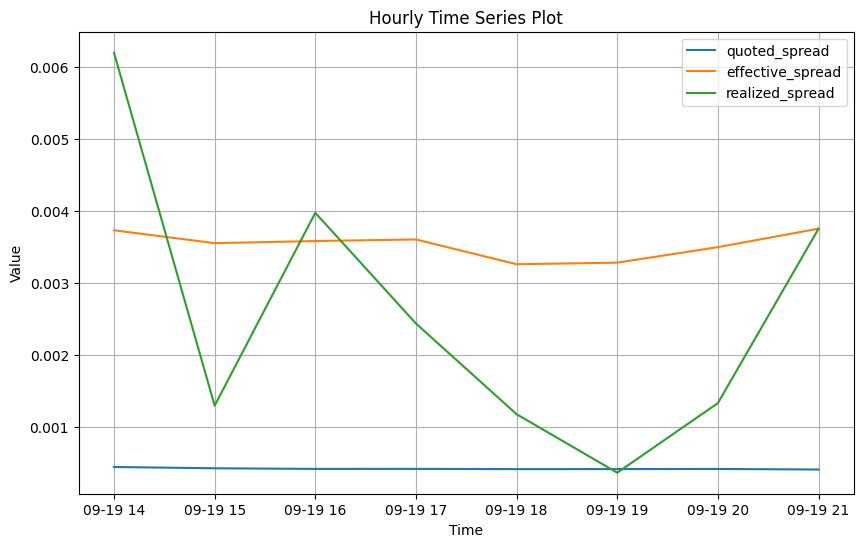

In [6]:
# Convert datatable DataFrame to pandas DataFrame
df_pandas = trade_df.to_pandas()

import pandas as pd
# Convert index to datetime format
df_pandas['date'] = pd.to_datetime(df_pandas.date)
df_pandas.set_index('date', inplace=True)
df_pandas = df_pandas[['COND', 'quoted_spread', 'effective_spread', 'realized_spread']]
print(df_pandas.head(-10))
# Resample data by hour and calculate mean
df_hourly = df_pandas.resample('H').mean()

# Plot data
plt.figure(figsize=(10, 6))
for column in df_hourly.columns[-3:]:
    plt.plot(df_hourly.index, df_hourly[column], label=column)

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Hourly Time Series Plot")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
df_pandas = trade_df.to_pandas()
# Convert index to datetime format
df_pandas['date'] = pd.to_datetime(df_pandas.date)
df_pandas.set_index('date', inplace=True)
df_pandas = df_pandas[['COND', 'EX', 'quoted_spread', 'effective_spread', 'realized_spread']]

average_spread = df_pandas.groupby('EX').agg({'quoted_spread': 'mean', 'effective_spread': 'mean', 'realized_spread': 'mean'})

print(average_spread)

    quoted_spread  effective_spread  realized_spread
EX                                                  
A        0.000448          0.004352         0.031574
B        0.000405          0.003554         0.001162
J        0.000404          0.004569         0.001122
K        0.000460          0.002747         0.004042
M        0.000462          0.004259         0.008580
N        0.000418          0.002902         0.003492
P        0.000434          0.003052         0.000679
T        0.000442          0.002540         0.004959
V        0.000410          0.002898         0.001376
X        0.000420          0.003613        -0.006053
Y        0.000404          0.004392         0.002055
Z        0.000431          0.002054         0.002703


#### Order Sign Correlation
As discussed in the lecture, order spliting is common for informed investors to minimize their price impact. How to empirically check this? One possibility is to examine auto-correlation of orders. With Lee and Ready algorithm, we have a sense how liquidity demanders (informed investors) trade. We start with some simple analysis to check how signed orders are correlated, and then check how to better fit the data to predict sign of next orders. Intuitively, the market makers have a good model to do so, they can 1) front-run investors to profit more, 2) adjust bid-ask prices and market depth to avoid being adversly selected by informed investors. 

1. autocorrelation plot of order sign 
2. re-produce the above figure in log term (both x-axis and y-axis are in log term)
3. fit regressions to check whehter past information can predict future order signs. 

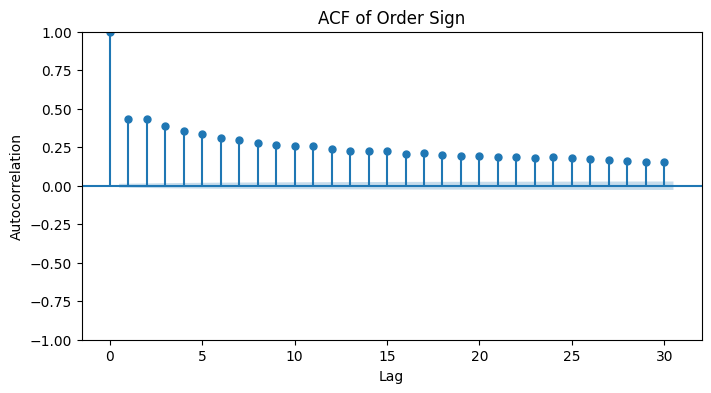

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF
plt.figure(figsize=(8, 4))
plot_acf(df_pandas['COND'], lags=30, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of Order Sign')
plt.show()

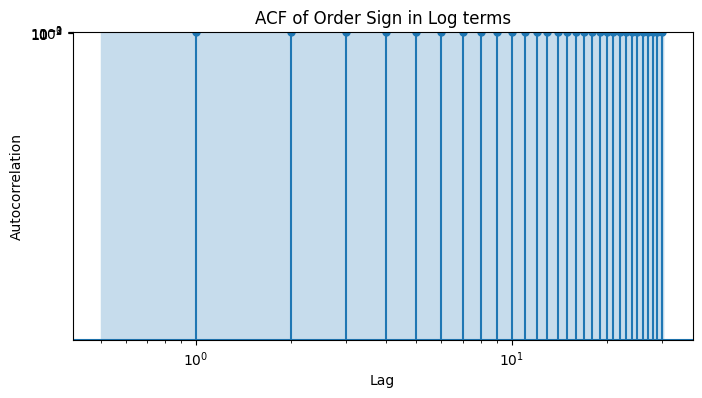

In [9]:
# Plot ACF
plt.figure(figsize=(8, 4))
plot_acf(df_pandas['COND'], lags=30, ax=plt.gca())
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of Order Sign in Log terms')
plt.show()

In [10]:
import statsmodels.api as sm
df = df_pandas[['COND']]
for i in range(1, 16):   # based on the ACF plot we took 15 lags
    df[f'lag_{i}'] = df['COND'].shift(i)

# Drop rows with missing values introduced by shifting
df.dropna(inplace=True)

# Split data into features (X) and target (y)
X = df.iloc[:, -15:]  # Use lagged features
y = df['COND']

# Add constant to the features
X = sm.add_constant(X)

# Fit OLS (Ordinary Least Squares) regression model
model = sm.OLS(y, X).fit()

# Print summary statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   COND   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     710.2
Date:                Wed, 21 Feb 2024   Prob (F-statistic):               0.00
Time:                        00:25:13   Log-Likelihood:                -28603.
No. Observations:               24445   AIC:                         5.724e+04
Df Residuals:                   24429   BIC:                         5.737e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.005     -0.724      0.4

/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_69087/3778300692.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{i}'] = df['COND'].shift(i)
/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_69087/3778300692.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{i}'] = df['COND'].shift(i)
/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_69087/3778300692.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

#### Question 3 Quote data
As we discussed in the class, not only transacted orders are informative, orders sitting on the books could potential provide some valuation information. In this exercise, we try to test this idea to see whether inbalance order book can help form some trading signals.  

Data BAC_nbbo.csv is order bood data (only the best quotes), with each row one of the price or size at the best bid or ask changes which corresponds to change in the supply or demand. 
* Calculate order imbalance OFI (keep only Nasdaq exchanges)
* Aggregate OFI to second level (take summation)

##### Order Imbalance
Order flow imbalance represents the changes in supply and demand. 
* Best bid or size at the best bid increase -> increase in demand.
* Best bid or size at the best bid decreases -> decrease in demand.
* Best ask decreases or size at the best ask increases -> increase in supply.
* Best ask increases or size at the best ask decreases -> decrease in supply.

Mathematically we summarise these four effects at from time $n-1$ to $n$ as:
$$e_n = I_{B_n \geq B_{n-1}} q_n - I_{B_n \leq B_{n-1}} q_{n-1} - I_{A_n \leq A_{n-1}} q_n + I_{A_n \geq A_{n-1}} q_{n-1} $$
where $B_n$ is the beset Bid price at time $n$ and $q_n$ is the size at those prices, and I is an indicator function. For exampel, $I_{B_n \geq B_{n-1}} = 1$ if $B_n \geq B_{n-1}$ and 0, otherwise. 


In [17]:
# Load the CSV file into a DataFrame
df = pd.read_csv("./BAC_nbbo.csv")

/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_69087/1948102664.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./BAC_nbbo.csv")


In [18]:
# Creat second stamp
df['TIME_M'] = pd.to_datetime(df['TIME_M'])

/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_69087/3692599462.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TIME_M'] = pd.to_datetime(df['TIME_M'])


In [25]:
## only keep trading hours
df.set_index('TIME_M', inplace=True)

In [27]:
# notice the extreme values in BID and ASK!! 
# need to clean data 
# first, remove negative spreads
# then outlier quotes
df['Spread'] = df['ASK'] - df['BID']
df = df[df['Spread'] >= 0]

Q1 = df[['BID', 'ASK']].quantile(0.25)
Q3 = df[['BID', 'ASK']].quantile(0.75)
IQR = Q3 - Q1

outliers_column1 = ((df['BID'] < (Q1['BID'] - 1.5 * IQR['BID'])) | 
                    (df['BID'] > (Q3['BID'] + 1.5 * IQR['BID'])))
outliers_column2 = ((df['ASK'] < (Q1['ASK'] - 1.5 * IQR['ASK'])) | 
                    (df['ASK'] > (Q3['ASK'] + 1.5 * IQR['ASK'])))

df.loc[outliers_column1, 'BID'] = np.nan
df.loc[outliers_column2, 'ASK'] = np.nan

df = df.dropna(subset=['BID', 'ASK'])
df = df[df['EX'] == 'N']

In [28]:
df['increase demand indicator'] = 0  # Initialize the column with zeros
df['decrease demand indicator'] = 0  # Initialize the column with zeros
df['increase supply indicator'] = 0  # Initialize the column with zeros
df['decrease supply indicator'] = 0  # Initialize the column with zeros

#previous value columns
df['bid_shifted'] = df['BID'].shift(1)
df['ask_shifted'] = df['ASK'].shift(1)
df['bidsize_shifted'] = df['BIDSIZ'].shift(1)
df['asksize_shifted'] = df['ASKSIZ'].shift(1)



# Apply conditions
df.loc[(df['BID'] > df['bid_shifted']) | (df['BIDSIZ'] > df['bidsize_shifted']), 'increase demand indicator'] = 1
df.loc[(df['BID'] < df['bid_shifted']) | (df['BIDSIZ'] < df['bidsize_shifted']), 'decrease demand indicator'] = 1
df.loc[(df['ASK'] < df['ask_shifted']) | (df['ASKSIZ'] > df['asksize_shifted']), 'increase supply indicator'] = 1
df.loc[(df['ASK'] > df['ask_shifted']) | (df['ASKSIZ'] < df['asksize_shifted']), 'decrease supply indicator'] = 1

# OFI column
df['OFI'] = (df['increase demand indicator'] * df['BIDSIZ']) - (df['decrease demand indicator'] * df['bidsize_shifted'])- (df['increase supply indicator'] * df['ASKSIZ'])+ (df['decrease supply indicator'] * df['asksize_shifted'])
df['Mid price'] = 0.5 * (df['BID'] + df['ASK'])

In [37]:
# Aggregate by second
# Construct return as log difference of last mid price and first mid price of each second
# Resample to get the first and last price of every second
# print(df.head())
# sub_df = df[['Mid price', 'OFI']]
first_prices = df['Mid price'].resample('1S').first()
last_prices = df['Mid price'].resample('1S').last()
# Calculate log returns
log_returns = np.log(last_prices / first_prices)

total_OFI_by_sec = df['OFI'].resample('1S').sum()

merged_df = pd.DataFrame({
    'log_returns': log_returns,
    'total_OFI': total_OFI_by_sec
})

# Drop NaN values that may result from resampling
merged_df.dropna(inplace=True)

Using OFI to generate trading signal: first do train/test split by selecting the first 70% of the data

In [38]:
# Test whether OFI can explain return variations in train data
split_point = int(len(merged_df) * 0.7)
train_df = merged_df.iloc[:split_point]
test_df = merged_df.iloc[split_point:]

# Adding a constant for the intercept
X_train = sm.add_constant(train_df['total_OFI'])
y_train = train_df['log_returns']

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Check the summary for R-squared value
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_returns   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     3136.
Date:                Wed, 21 Feb 2024   Prob (F-statistic):               0.00
Time:                        00:39:37   Log-Likelihood:             1.1449e+05
No. Observations:               14080   AIC:                        -2.290e+05
Df Residuals:                   14078   BIC:                        -2.290e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.578e-07      6e-07      0.930      0.3

In [ ]:
# explainatry power for test sample

##### Construct a Predictive Trading Signal
BUT! The above analysis is in-sample. We want to see out-sample results. 

In [39]:
# calculate one-second ahead return
merged_df['lagged_OFI'] = merged_df['total_OFI'].shift(1)

# Drop NaN values that might have been introduced by shifting
merged_df.dropna(inplace=True)

In [40]:
# Test whether OFI can explain FUTURE return variations
# Split sample to test and train samples again 
# Test whether lagged OFI can predict FUTURE return
split_point = int(len(merged_df) * 0.7)
train_df = merged_df.iloc[:split_point]
test_df = merged_df.iloc[split_point:]

# Fit the model on the training set
X_train = sm.add_constant(train_df['lagged_OFI'])
y_train = train_df['log_returns']

model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_returns   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     39.14
Date:                Wed, 21 Feb 2024   Prob (F-statistic):           4.06e-10
Time:                        00:40:45   Log-Likelihood:             1.1309e+05
No. Observations:               14079   AIC:                        -2.262e+05
Df Residuals:                   14077   BIC:                        -2.262e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.553e-07   6.62e-07      0.385      0.7

In [41]:
# explainatry power for test sample
X_test = sm.add_constant(test_df['lagged_OFI'])
y_test = test_df['log_returns']

# Predict
predictions = model.predict(X_test)

# Calculate and plot cumulative returns from predictions for the test set
test_df['predicted_signal'] = np.where(predictions > 0, 1, -1)

/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_69087/3620246845.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_signal'] = np.where(predictions > 0, 1, -1)


/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_69087/185402073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['strategy_returns'] = test_df['predicted_signal'] * test_df['log_returns']
/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_69087/185402073.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['cumulative_strategy_returns'] = test_df['strategy_returns'].cumsum()
/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_69087/185402073.py:5: SettingWithCopyW

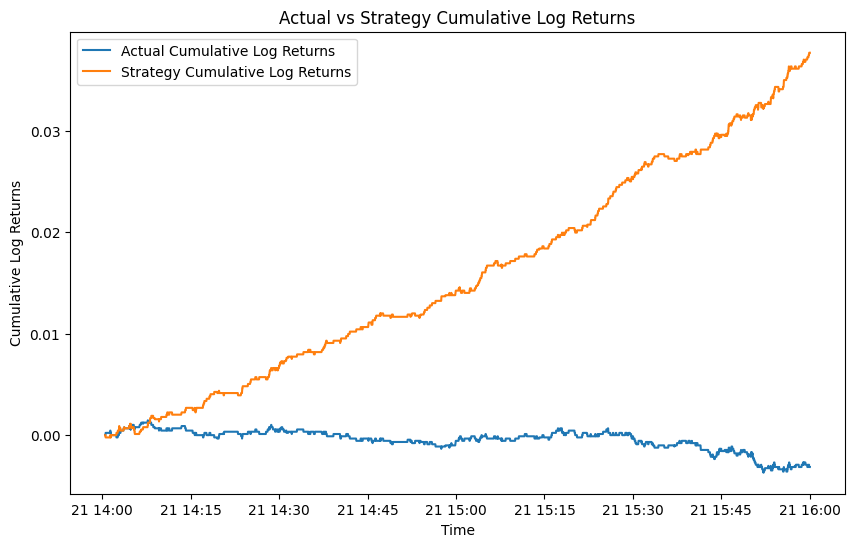

In [45]:
# plots cummulative return of the strategy using signal from past OFI

test_df['strategy_returns'] = test_df['predicted_signal'] * test_df['log_returns']
test_df['cumulative_strategy_returns'] = test_df['strategy_returns'].cumsum()
test_df['cumulative_actual_returns'] = test_df['log_returns'].cumsum()
# Plot
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df['cumulative_actual_returns'], label='Actual Cumulative Log Returns')
plt.plot(test_df.index, test_df['cumulative_strategy_returns'], label='Strategy Cumulative Log Returns')
plt.title('Actual vs Strategy Cumulative Log Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Log Returns')
plt.legend()
plt.show()